##### Imports nécessaires pour tout le reste

In [222]:
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None # supprime certains warnings
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
import xgboost as xgb
import numpy as np
import os
import cv2


# Récupération du Dataset

> L'ordre des opérations ici ne correspond pas à l'ordre dans lequel les opérations ont réellement été faites (les récupérations de datasets du gouvernement ayant été réalisés au fur et à mesure du rajout de traitements) mais représente une version la plus compréhensible possible

> On récupère le fichier contenant l'ensemble des données finales.

In [223]:
# X_AC = pd.read_csv("../traitement_photos/X_avec_prix_et_images_complet_et_inflation.csv")

X_train_site = pd.read_csv("./X_train_J01Z4CN.csv")
X_test_site = pd.read_csv("./X_test_BEhvxAN.csv")

# X_AC correspond à l'ensemble des données test et train compris (X_AC = X_AC)
X_AC = pd.concat([X_train_site,X_test_site],ignore_index=True)

# X_train = pd.read_csv("../Prix_metre/X_train_avec_prix.csv")

X = X_AC.iloc[:len(X_train_site),:]

y = pd.read_csv("./y_train_OXxrJt1.csv")
y = y[["price"]] # On ne garde que la colonne price, un supprime la colonne qui porte sur le numéro de l'annonce

X.head(5)

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,...,0.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,...,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


> On aura régulièrement besoin d'une colone "département". Nous la créons donc dès maintenant sur l'entiereté du dataset

In [224]:
X_AC["departement"]=X_AC["postal_code"]
X_AC["departement"][X_AC["departement"] < 10000]=X_AC["departement"].astype(str).str[:1].astype(int)
X_AC["departement"][X_AC["departement"] >= 10000]=X_AC["departement"].astype(str).str[:2].astype(int)

# Récupération de données à partir d'autres datasets

### Dataset de l'INSEE

> On récupère le dataset et on effectue quelques traitements dessus

In [225]:
insee = pd.read_excel("./Prix_metre/Data_auxiliaires/MDB-INSEE-V2.xls")
insee.columns

# Suppression des lignes où CODGEO contient des lettres
insee = insee[insee["CODGEO"].apply(lambda x: x.isnumeric())]

# On convertit CODGEO en int
insee["CODGEO"] = insee["CODGEO"].astype(int)

# On drop les colomnes de types "object"
for col in insee.columns:
    if insee[col].dtype == "object":
        insee = insee.drop(col, axis=1)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


> Il était au départ prévu d'effectuer une moyenne par département des colonnes afin de pouvoir rapprocher les "CODGEO" aux valeurs des départements, cependant les résultats n'étaient pas concluants

> On effectue une jointure entre notre dataset X_AC et celui de l'INSEE

In [226]:
X_AC = X_AC.merge(insee, left_on="postal_code", right_on="CODGEO", how="left")

### Jointure avec un dataset du gouvernement portant sur les chiffres de 2019 pour l'immobilier et sur certains de 1819

In [227]:
X_prix = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/Prix_metre/prixm2-loyer-communes-2019.csv")

> Le dataset étant particulier, de nombreux traitements ont du être effectués à la main

> On recherche les lignes dont le nom de la commune est 'VILLENEUVE-LOUBET' ou 'VILLENEUVE LOUBET' afin de détecter des doublons

In [228]:
X_prix[X_prix['NOM_COM_M'] == 'VILLENEUVE-LOUBET']

X_prix[X_prix['NOM_COM_M'] == 'VILLENEUVE LOUBET']

,X,ID,INSEE_COM,INSEE_DEP,INSEE_REG,CODE_EPCI,NOM_COM_M,POPULATION,Nb_Ventes,PrixMoyen_M2,PrixMoyen_M2_1819,loyer_apparts,loyer_maisons,R2appart,R2maison
30502,28791,COMMUNE_0000000009759378,6161,6,93,240600585.0,VILLENEUVE LOUBET,14672,514,5175,5126.873267,17.814233,17.313669,0.809506,0.847442


> On supprime le mot "ARRONDISSEMENT" de la colonne NOM_COM_M


In [229]:
liste_avant = ['ARRONDISSEMENT','1E', '2E', '3E', '4E', '5E', '6E', '7E', '8E', '9E', '10E', '11E', '12E', '13E', '14E', '15E', '16E', '17E', '18E', '19E', '20E','1eme ', '2eme ', '3eme ', '4eme ', '5eme ', '6eme ', '7eme ', '8eme ', '9eme ', '10eme ', '11eme ', '12eme ', '13eme ', '14eme ', '15eme ', '16eme ', '17eme ', '18eme ', '19eme ', '20eme ']
liste_apres = ['','1eme', '2eme', '3eme', '4eme', '5eme', '6eme', '7eme', '8eme', '9eme', '10eme', '11eme', '12eme', '13eme', '14eme', '15eme', '16eme', '17eme', '18eme', '19eme', '20eme','1eme', '2eme', '3eme', '4eme', '5eme', '6eme', '7eme', '8eme', '9eme', '10eme', '11eme', '12eme', '13eme', '14eme', '15eme', '16eme', '17eme', '18eme', '19eme', '20eme ','1eme', '2eme', '3eme', '4eme', '5eme', '6eme', '7eme', '8eme', '9eme', '10eme', '11eme', '12eme', '13eme', '14eme', '15eme', '16eme', '17eme', '18eme', '19eme', '20eme ']

for i in range(len(liste_avant)):
    X_prix['NOM_COM_M'] = X_prix['NOM_COM_M'].str.replace(liste_avant[i], liste_apres[i])

> On passe en minuscule la colonne 'NOM_COM_M' et on enlève les "-" entre les mots

In [230]:
X_prix['NOM_COM_M'] = X_prix['NOM_COM_M'].str.lower()
X_prix['NOM_COM_M'] = X_prix['NOM_COM_M'].str.replace('-', ' ')
X_AC['city'] = X_AC['city'].str.replace('-', ' ')

In [231]:
X_prix.head()

,X,ID,INSEE_COM,INSEE_DEP,INSEE_REG,CODE_EPCI,NOM_COM_M,POPULATION,Nb_Ventes,PrixMoyen_M2,PrixMoyen_M2_1819,loyer_apparts,loyer_maisons,R2appart,R2maison
0,23997,ARR_MUNI0000000009736033,75120,75,11,NaN,paris 20eme,195604,2039,8604,8333.889908,25.218065,25.531480,0.852356,0.742222
1,23507,ARR_MUNI0000000009736034,75119,75,11,NaN,paris 19eme,186393,1838,8263,8065.033908,25.184404,24.829411,0.846309,0.742222
2,13728,ARR_MUNI0000000009736035,75111,75,11,NaN,paris 11eme,147017,1127,9819,9534.497086,29.223528,30.939697,0.878908,0.780490
3,976,ARR_MUNI0000000009736040,75118,75,11,NaN,paris 18eme,195060,3503,9162,8865.722421,27.585489,28.273577,0.829814,0.742222
4,4795,ARR_MUNI0000000009736041,75117,75,11,NaN,paris 17eme,167835,2775,10205,9910.312961,30.177892,30.443554,0.934215,0.842951


> On effectue une jointure des deux tables afin de ne garder que les lignes de X_prix qui ont une correspondance dans X_AC

In [232]:
X_AC = X_AC.merge(X_prix, how='left', left_on='city', right_on='NOM_COM_M')

> On supprime les doublons et on vérifie ensuite le nombre de valeurs manquantes

In [233]:
print(X_AC.shape)
print(X_AC[["id_annonce"]].duplicated().sum())
X_AC = X_AC.drop_duplicates(subset=["id_annonce"], keep="first")

X_AC[["PrixMoyen_M2"]].isnull().sum()

(52697, 130)
5990


PrixMoyen_M2    5244
dtype: int64

> Pour les 10% sans valeurs, on met la valeur moyenne du département

In [234]:
X_AC['PrixMoyen_M2'].fillna(X_AC.groupby('departement')['PrixMoyen_M2'].transform('mean'), inplace=True)

> S'il reste encore des valeurs manquantes, on remplit avec la moyenne globale

In [235]:
X_AC['PrixMoyen_M2'].fillna(X_AC['PrixMoyen_M2'].mean(), inplace=True)

### Rajout de features à l'aide de deux autres datasets portant sur les données de 2017 et 2018

In [245]:
dataset_2017 = pd.read_csv("./Prix_metre/prixm2-communes-2017.csv")
dataset_2017.head(5)

,STATUT,INSEE_COM,NOM_COM,INSEE_ARR,NOM_DEP,INSEE_DEP,NOM_REG,INSEE_REG,CODE_EPCI,NOM_COM_M,Prixm2
0,Commune simple,54166,Dommartin-la-Chaussée,4,MEURTHE-ET-MOSELLE,54,GRAND EST,44,200070738,DOMMARTIN-LA-CHAUSSEE,NaN
1,Sous-préfecture,54099,Val de Briey,1,MEURTHE-ET-MOSELLE,54,GRAND EST,44,200070845,VAL DE BRIEY,1187.0
2,Commune simple,55270,Lahayville,2,MEUSE,55,GRAND EST,44,200034874,LAHAYVILLE,NaN
3,Commune simple,60196,La Drenne,1,OISE,60,HAUTS-DE-FRANCE,32,246000582,LA DRENNE,1867.0
4,Commune simple,72054,Champagné,2,SARTHE,72,PAYS DE LA LOIRE,52,247200132,CHAMPAGNE,1164.0


In [246]:
dataset_2018 = pd.read_csv("./Prix_metre/communes-dvf-2018.csv")
dataset_2018.head(5)

,Unnamed: 0,ID,INSEE_COM,CODE_EPCI,INSEE_DEP,INSEE_REG,NOM_COM_M,POPULATION,Nb_Transac,Prixm2_Moy
0,1,COMMUNE_0000000009728958,02451,240200493.0,02,32,MAGNY LA FOSSE,125,1.0,854.0
1,2,COMMUNE_0000002200276464,01227,200040350.0,01,84,MAGNIEU,640,7.0,1437.0
2,3,COMMUNE_0000000009728784,02061,240200493.0,02,32,BECQUIGNY,260,1.0,530.0
3,4,COMMUNE_0000002200276482,14514,241400878.0,14,28,PONT L EVEQUE,4740,46.0,2593.0
4,5,COMMUNE_0000000009729157,02374,240200493.0,02,32,LEHAUCOURT,886,10.0,1204.0


In [254]:
def insertion(dataset,nom_col):
    # delete row with A or B in INSEE_COM
    dataset = dataset[~dataset[f"{nom_col}"].str.contains("A|B")]
    # column from str to int
    dataset[f"{nom_col}"] = dataset[f"{nom_col}"].astype(int)
    # drop object columns
    for x in dataset.columns:
        if dataset[x].dtype == "object":
            dataset.drop(x, axis=1, inplace=True)

    X_AC = X_AC.merge(X_prix, how='left', left_on='postal_code', right_on=f"{nom_col}")
    return X_AC

X_AC = insertion(dataset_2017,"INSEE_COM")
X_AC = insertion(dataset_2018,"INSEE_COM")

2451

### Rajout de features en tenant compte de l'inflation à l'aide d'un autre dataset de l'INSEE


> On crée un peu en avance une feature de nearly_price (on la supprimera après afin de ne pas intérférer avec la partie de Feature Engineering située plus loin dans le notebook) à l'aide du dataset précédent

In [236]:
X_AC["nearly_price"]=X_AC["PrixMoyen_M2"]*X_AC["size"]

> On initialise une colonne "nearly_price_inflation" avec None

In [237]:
X_AC["nearly_price_inflation"]=None

> On traite ensuite cette colonne en fonction du type de bien et du département. Toutes les données des taux d'inflation ont été ajouté à la main ici, car le fichier de l'INSEE correspondant était peu exploitable en Python directement.

In [238]:
departements_dataset = X_AC["departement"].unique().tolist()
# departements présents explicitement dans la base de données de l'INSEE
departements = [75,77,78,91,92,93,94,95,4,5,6,13,83,84,1,3,7,15,26,38,42,43,63,69,73,74,2,59,60,62,80]
taux_inflation_apparts = [1.034802784,1.067698259,1.068328717,1.070949185,1.08037225,1.094952951,1.089005236,1.074144487,1.066918002,1.066918002,1.066918002,1.066918002,1.066918002,1.066918002,1.114111498,1.114111498,1.114111498,1.114111498,1.114111498,1.114111498,1.114111498,1.114111498,1.114111498,1.114111498,1.114111498,1.114111498,1.110377358,1.110377358,1.110377358,1.110377358,1.110377358]
taux_inflation_maison = [1.034802784,1.092380952,1.075418994,1.080449018,1.097797357,1.094977169,1.099188458,1.086997194,1.083409716,1.083409716,1.083409716,1.083409716,1.083409716,1.083409716,1.095829636,1.095829636,1.095829636,1.095829636,1.095829636,1.095829636,1.095829636,1.095829636,1.095829636,1.095829636,1.095829636,1.095829636,1.088180113,1.088180113,1.088180113,1.088180113,1.088180113]



# On remplit les valeurs pour les maisons et les apparts dont on a les numéros
for i in range(len(departements)):
    X_AC["nearly_price_inflation"][(X_AC["property_type"] == "appartement") & (X_AC["departement"] == departements[i])] = X_AC["nearly_price"][(X_AC["property_type"] == "appartement") & (X_AC["departement"] == departements[i])] * taux_inflation_apparts[i]
    X_AC["nearly_price_inflation"][(X_AC["property_type"] == "maison") & (X_AC["departement"] == departements[i])] = X_AC["nearly_price"][(X_AC["property_type"] == "maison") & (X_AC["departement"] == departements[i])] * taux_inflation_maison[i]

province_apparts = 1.106019766
province_maisons = 1.101083032

departements_not_in_INSEE = [dep for dep in departements_dataset if dep not in departements]

for dep in departements_not_in_INSEE:
# on remplit les valeurs pour les maisons et les apparts dont on a pas les numéros (donc "Province")
    X_AC["nearly_price_inflation"][(X_AC["property_type"] == "appartement") & (X_AC["departement"] == dep)] = X_AC["nearly_price"][(X_AC["property_type"] == "appartement") & (X_AC["departement"] == dep)] * province_apparts
    X_AC["nearly_price_inflation"][(X_AC["property_type"] == "maison") & (X_AC["departement"] == dep)] = X_AC["nearly_price"][(X_AC["property_type"] == "maison") & (X_AC["departement"] == dep)] * province_maisons


> Pour le reste des types (non présents dans le dataset), on remplit par la valeur moyenne du département :

In [239]:
X_AC["nearly_price_inflation"] = X_AC.groupby("departement")["nearly_price_inflation"].transform(lambda x: x.fillna(x.mean()))

In [240]:
X_AC = X_AC.drop(columns=["nearly_price"])

# Création des scores des images

> Nous avons adapté un modèle de Deep Learning pré entrainée nommée RoomNet à la détection de pièces, pour pouvoir l'utiliser sur nos images. L'adaptation n'est pas visible car celle-ci a été effectué directement dans les fichiers d'origines de RoomNet récupérés sur Github

In [24]:
CLASS = ['Backyard', 'Bathroom', 'Bedroom', 'Frontyard', 'Kitchen', 'LivingRoom']
POND = [2, 0.5, 1, 1.5, 1.5, 2]

> Traitement des fichiers excels obtenus avec RoomNet pour obtenir un unique Dataframe avec un score en fonction des images pour chaque annonce. Chaque pièce se voit attribuer un coefficient d'importance qui est ensuite multiplié par le nombre d'images de la pièce en question avant d'être sommé pour chaque annonce aux autres scores des autres images

In [25]:
def score(id_dataset):
    if id_dataset == "train":
        path_to_csv = "C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/_classified/train"

    elif id_dataset == "test":
        path_to_csv = "C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/_classified/test"

    list_of_files = os.listdir(path_to_csv)  # On récupère la liste de l'ensemble des fichiers .csv créées à l'aide du modèle de DL RoomNet 
    
    # création du dictionnaire final, qui contiendra toutes les données des excels et les scores (sans les valeurs de fiabilité)
    donnees_finales = pd.DataFrame({'id_annonce':[],'Backyard' : [], 'Bathroom' : [], 'Bedroom' : [], 'Frontyard' : [],'Kitchen' : [], 'LivingRoom' : [],'score':[]})
    dict_operations = {'Value_Count': ('PREDICTED_LABEL', 'count'), 'average_fiability': ('Unnamed: 2', 'mean')} # dictionnaire qui contient les opérations à effectuer sur les colonnes des dataframes qu'on récup

    i=0
    for file in list_of_files:
        if i%1000 == 0: # compteur pour suivre l'avancement du traitement
            print(i)
        i = i+1
        A = pd.read_excel(path_to_csv + "/" + file)
        elem_presents = A.groupby('PREDICTED_LABEL', as_index=False).agg(**dict_operations) # on crée un dataframe avec le count des différentes classes et la fiabilité moyenne par classe

        dict_temp = {} # création du dictionnaire temporaire qui contiendra la valeurs avant de les mettre dans le dataframe final
        score = 0 # initialisation du score
        for elem in elem_presents['PREDICTED_LABEL']:
            number_of_elem = elem_presents['Value_Count'][elem_presents['PREDICTED_LABEL'] == elem].tolist()[0] # on récupère le nombre d'éléments de la classe
            average_fiability = elem_presents['average_fiability'][elem_presents['PREDICTED_LABEL'] == elem].tolist()[0] # on récupère la fiabilité moyenne de la classe
            dict_temp[elem] = [number_of_elem] # on met le nombre d'éléments de la classe dans le dictionnaire
            score = score + number_of_elem*POND[CLASS.index(elem)]*average_fiability # on calcule le score en multipliant notre pondération et la fiabilité moyenne de la classe

        score = [score]
        dict_temp['score'] = score # on ajoute le score au dictionnaire
        dict_temp['id_annonce'] = file[4:-12] # on ajoute l'id de l'annonce au dictionnaire

        temp = pd.DataFrame(dict_temp)
        donnees_finales = pd.concat([donnees_finales,temp],ignore_index=True)
    return(donnees_finales)

In [26]:
donnees_finales_X=train = score("train")
donnees_finales_X.to_csv('donnees_images_train.csv', index=False)

donnees_finales_X_test=test = score("test")
donnees_finales_X_test.to_csv('donnees_images_test.csv', index=False)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [27]:
image_test = pd.read_csv('donnees_images_test.csv')
image_train = pd.read_csv('donnees_images_train.csv')

> Concaténation de test et train

In [28]:
image = pd.concat([image_test,image_train],ignore_index=True)

> Jointure de X_AC et image grâce à la colonne "id_annonce"

In [29]:
X_AC = pd.merge(X, image, on='id_annonce', how='left')

# Second traitement des images (non retenu au final)

> On commence par spécifier les PATHs vers les images

In [ ]:
# listes des dossiers dans le dossier train
FOLDER_TRAIN = 'C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/reduced_images_ILB/reduced_images/train'
list_folders_train = os.listdir(FOLDER_TRAIN)
# liste des dossiers dans le dossier test
FOLDER_TEST = 'C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/reduced_images_ILB/reduced_images/test'
list_folders_test = os.listdir(FOLDER_TEST)

> On calcule la moyenne des pixels en passant en teintes de gris ainsi que le premier et le troisième quartiles 

In [ ]:
def traitement_images(Folder,list_folders):
    futur_dataset = {"id_annonce" : [],"gray_mean" : [], "quartile_inf" : [], "quartile_sup" : []}

    compteur = 0
    for dossier in list_folders :
        compteur += 1
        # création d'un compteur pour voir l'avancement
        if compteur % 1000 == 0 :
            print(compteur)
        # path absolue vers le folder
        folder_path = Folder + "/" + dossier
        list_images = os.listdir(folder_path)
        for image in list_images :
            quartile_inf_image = []
            quartile_sup_image = []
            moy_image = []

            image_path = folder_path + "/" + image
            img = cv2.imread(image_path)
            # On passe l'image en gris
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # moyenne des pixels de l'image
            moy_image.append(gray_img.mean())
            # On calcule les quartiles de l'image
            quartiles = np.quantile(gray_img, [0.25, 0.75])
            quartile_inf_image.append(quartiles[0])
            quartile_sup_image.append(quartiles[1])
            # On ajoute l'image au futur dataset avec son id d'annonce
        futur_dataset["id_annonce"].append(dossier[4:])
        futur_dataset["gray_mean"].append(mean(moy_image))
        futur_dataset["quartile_inf"].append(mean(quartile_inf_image))
        futur_dataset["quartile_sup"].append(mean(quartile_sup_image))
    return(futur_dataset)

In [ ]:
traitement_images_train = traitement_images(FOLDER_TRAIN,list_folders_train)
traitement_images_test = traitement_images(FOLDER_TEST,list_folders_test)

traitement_global = pd.concat([traitement_images_train,traitement_images_test],ignore_index=True)

# Feature Engineering

In [72]:
X = pd.read_csv('./X_train_J01Z4CN.csv')

### On crée une colonne département dont on aura besoin pour remplacer les valeurs nulles ensuite

In [73]:
# Calcul des valeurs des départements plutôt que des codes postaux (en séparant les départements à 4 chiffres des départements à 5 chiffres)
X["departement"]=X["postal_code"]
X["departement"][X["departement"] < 10000]=X["departement"].astype(str).str[:1].astype(int)
X["departement"][X["departement"] >= 10000]=X["departement"].astype(str).str[:2].astype(int)

### Etudes des colomnes à valeurs non numériques

> On étudie pour l'instant seulement le dataset de train, car on possède les valeurs des prix correspondants

In [74]:
s = (X.dtypes == 'object')    # pour avoir la liste des colonnes avec comme type "objet"
object_cols = list(s[s].index)

# On compte le nombre de valeurs différentes par colonne (pour après faire possiblement du One-Hot Encoding)
nb_val_col = {}
nb_val_manquantes = {}
ratio_val_manquantes = {}
for col in object_cols:
    nb_val_col[col]=[len(X[f"{col}"].value_counts())]
    nb_val_manquantes[col]=X[f"{col}"].isnull().sum() #on compte le nombre de valeurs manquantes pour savoir s'il faut garder la colonne
    ratio_val_manquantes[col]=nb_val_manquantes[col]/len(X[f"{col}"]) #on calcule le ratio de valeurs manquantes

nb_val_col_df = pd.DataFrame(nb_val_col.items(),columns = ["Nom Colonne","Nb de valeurs différentes"])
nb_val_manquantes = pd.DataFrame(nb_val_manquantes.items(),columns = ["Nom Colonne","Nb de valeurs manquantes"])
ratio_val_manquantes = pd.DataFrame(ratio_val_manquantes.items(),columns = ["Nom Colonne","Ratio de valeurs manquantes"])

nb_val_col_df["Nb de valeurs manquantes"]=nb_val_manquantes[["Nb de valeurs manquantes"]]
nb_val_col_df['Ratio de valeurs manquantes']=ratio_val_manquantes[["Ratio de valeurs manquantes"]]

nb_val_col_df

,Nom Colonne,Nb de valeurs différentes,Nb de valeurs manquantes,Ratio de valeurs manquantes
0,property_type,[22],0,0.000000
1,city,[8643],0,0.000000
2,energy_performance_category,[7],18300,0.489724
3,ghg_category,[7],18838,0.504121
4,exposition,[12],28274,0.756637


> On décide donc de drop exposition car il manque plus de 75% des valeurs

In [75]:
X = X.drop(columns = ["exposition"],axis=1)
X.shape

(37368, 27)

> ghg_category et energy_performance_category correspondent à la même information que ghg_value et energy_performance_value mais en moins précis donc on les enlève  

In [76]:
X.drop(columns=['ghg_category', 'energy_performance_category'], inplace=True)

> Pour floor et land_size on peut penser que les valeurs manquantes correspondent à des maisons pour floor et à des appartements pour land_size donc on les remplace par 0

In [77]:
X['floor'].fillna(0, inplace=True)
X['land_size'].fillna(0, inplace=True)

> On merge le dataset du feature engineering avec celui des données de 2019 car nous créerons plus loin une colomne pour du clustering


In [78]:
X_prix = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/Prix_metre/prixm2-loyer-communes-2019.csv")

liste_avant = ['ARRONDISSEMENT','1E', '2E', '3E', '4E', '5E', '6E', '7E', '8E', '9E', '10E', '11E', '12E', '13E', '14E', '15E', '16E', '17E', '18E', '19E', '20E','1eme ', '2eme ', '3eme ', '4eme ', '5eme ', '6eme ', '7eme ', '8eme ', '9eme ', '10eme ', '11eme ', '12eme ', '13eme ', '14eme ', '15eme ', '16eme ', '17eme ', '18eme ', '19eme ', '20eme ']
liste_apres = ['','1eme', '2eme', '3eme', '4eme', '5eme', '6eme', '7eme', '8eme', '9eme', '10eme', '11eme', '12eme', '13eme', '14eme', '15eme', '16eme', '17eme', '18eme', '19eme', '20eme','1eme', '2eme', '3eme', '4eme', '5eme', '6eme', '7eme', '8eme', '9eme', '10eme', '11eme', '12eme', '13eme', '14eme', '15eme', '16eme', '17eme', '18eme', '19eme', '20eme ','1eme', '2eme', '3eme', '4eme', '5eme', '6eme', '7eme', '8eme', '9eme', '10eme', '11eme', '12eme', '13eme', '14eme', '15eme', '16eme', '17eme', '18eme', '19eme', '20eme ']

for i in range(len(liste_avant)):
    X_prix['NOM_COM_M'] = X_prix['NOM_COM_M'].str.replace(liste_avant[i], liste_apres[i])

X_prix['NOM_COM_M'] = X_prix['NOM_COM_M'].str.lower()
X_prix['NOM_COM_M'] = X_prix['NOM_COM_M'].str.replace('-', ' ')
X['city'] = X['city'].str.replace('-', ' ')

X = X.merge(X_prix, how='left', left_on='city', right_on='NOM_COM_M')
X = X.drop_duplicates(subset=["id_annonce"], keep="first")
X['PrixMoyen_M2'].fillna(X.groupby('departement')['PrixMoyen_M2'].transform('mean'), inplace=True)
X['PrixMoyen_M2'].fillna(X['PrixMoyen_M2'].mean(), inplace=True)

> Pour le moment, on décide d'appliquer du Label Encoder à "city" et un One Hot Encoding à "property_type"

In [79]:
#one hot encoding for property_type
X = pd.get_dummies(X, columns=['property_type'], drop_first=False)

# Label encoding for city
le = LabelEncoder()
X['city'] = le.fit_transform(X['city'])


### On s'occupe maintenant des valeurs nulles de toutes les colonnnes 

In [80]:
colomnes = X.columns
nb_lignes = X.shape[0]
ratio_val_manquantes = {}


for col in colomnes:
    ratio_val_manquantes[col] = X[col].isnull().sum()/nb_lignes

ratio_val_manquantes = pd.DataFrame(ratio_val_manquantes.items(),columns = ["Nom Colonne","Ratio de valeurs manquantes"])
ratio_val_manquantes.sort_values(by = "Ratio de valeurs manquantes",ascending = False)

,Nom Colonne,Ratio de valeurs manquantes
9,ghg_value,0.504121
8,energy_performance_value,0.489724
12,nb_bathrooms,0.355197
29,CODE_EPCI,0.183526
34,PrixMoyen_M2_1819,0.136989
...,...,...
21,last_floor,0.000000
22,upper_floors,0.000000
23,departement,0.000000
1,approximate_latitude,0.000000


> On remplit les données manquantes avec pour certaines colonnes la moyenne du code postal, et pour d'autres la moyenne par département

In [91]:
X.drop(columns=['ID','INSEE_COM','INSEE_DEP','INSEE_DEP','NOM_COM_M'], inplace=True)

In [93]:
def features_incomplete(X):   
    Features_incomplete = []
    for x in X.columns:
        if X[x].isnull().sum()/len(X[x])*100 > 0:
            Features_incomplete.append(x)
    return Features_incomplete
    
for x in features_incomplete(X):
# On remplit le reste par la valeur moyenne du département
    X[x].fillna(X.groupby("departement")[x].transform("mean"), inplace=True)

### Etude de la corrélation entre les features

> On regarde la corrélation entre les features (en ajoutant le prix à prédire)

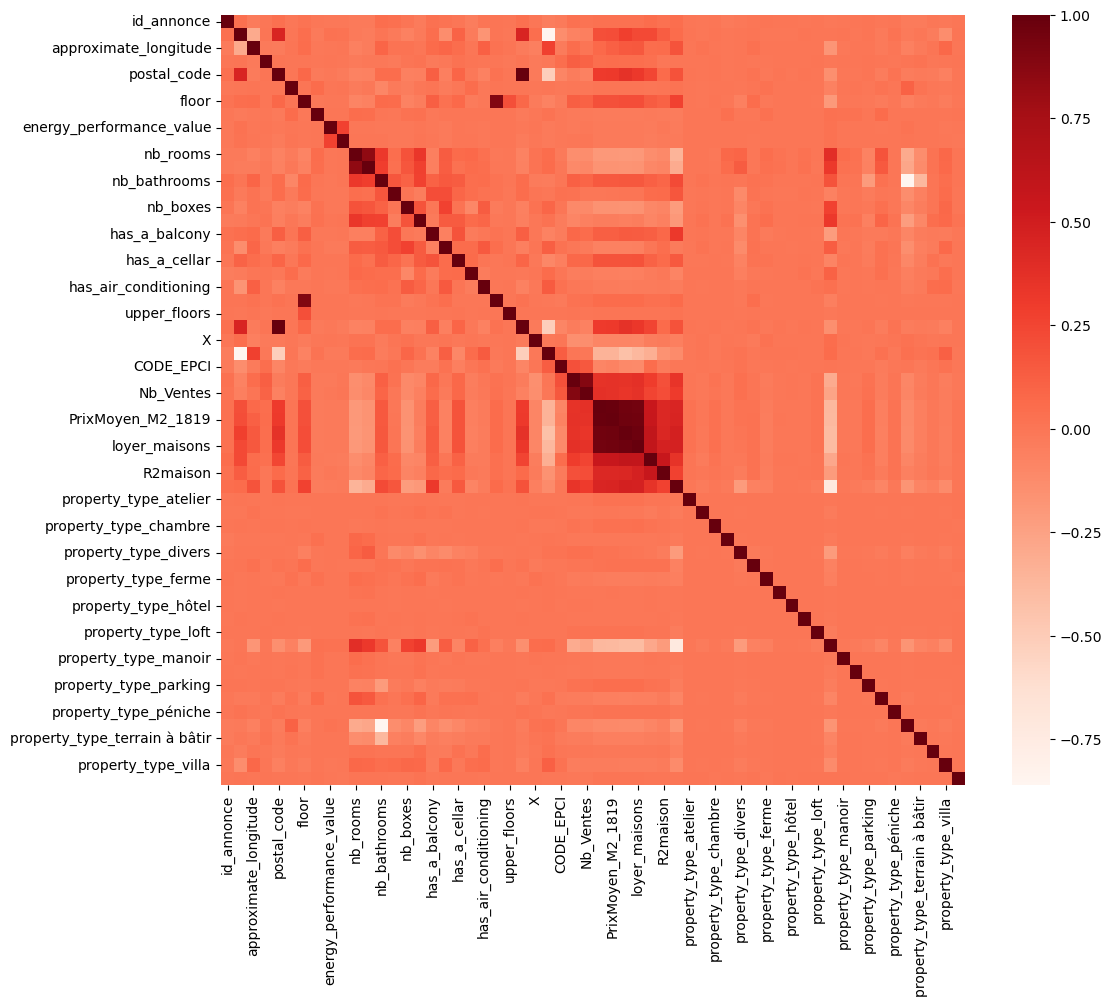

In [94]:
X_with_price = X.copy()
X_with_price["price"] = np.log1p(y["price"])

plt.figure(figsize=(12,10))
cor = X_with_price.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

> On remarque sur la matrice de corrélation, la forte corrélation entre le prix et nb_terraces, has_a_cellar, nb_photos, nb_rooms, nb_bedrooms, nb_bathrooms, postal_code. On refait une matrice de corrélation juste avec ses variables :

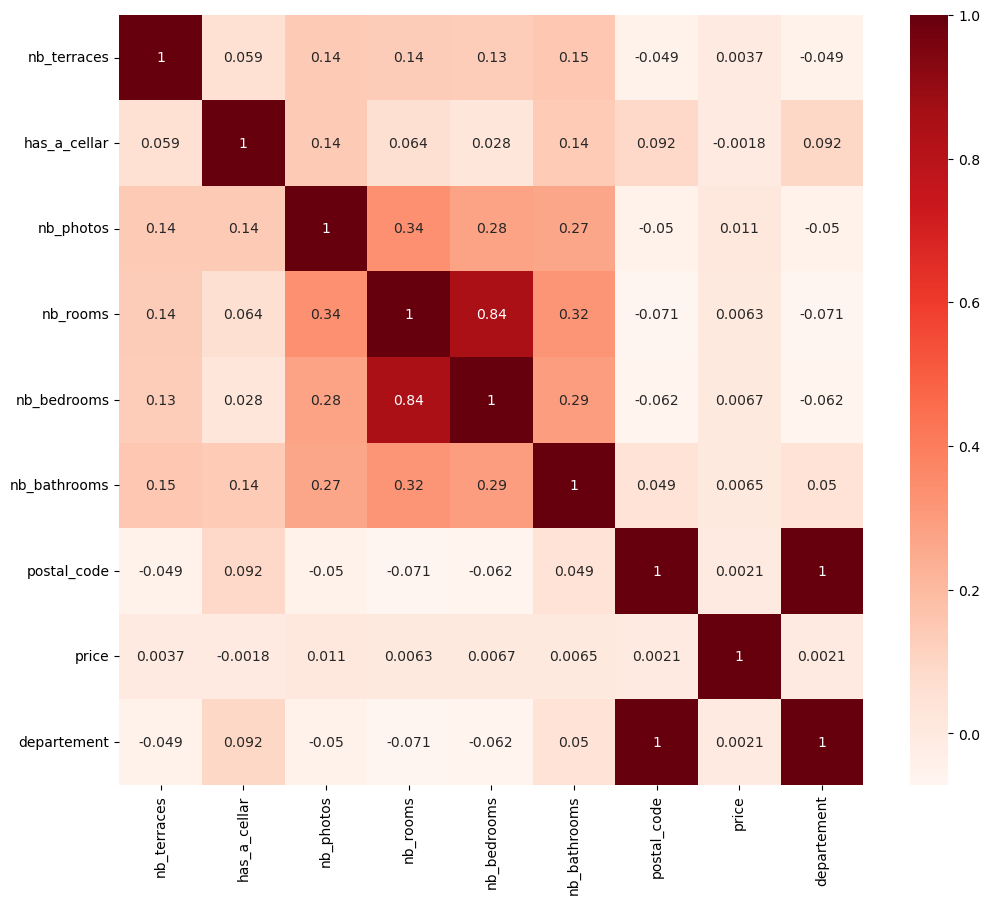

In [95]:
X_correlation = X_with_price[["nb_terraces", "has_a_cellar","nb_photos","nb_rooms","nb_bedrooms","nb_bathrooms","postal_code","price","departement"]]

plt.figure(figsize=(12,10))
cor = X_correlation.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

> On essaie alors de créer d'autres variables à partir de celles-ci

In [96]:
price = X_correlation["price"]
X_correlation = X_correlation.drop(columns = ["price"],axis=1)
X_correlation["Sum_bedrooms_rooms"] = X_correlation["nb_rooms"]+X_correlation["nb_bedrooms"]
X_correlation["Sum_bathrooms_rooms"] = X_correlation["nb_rooms"]+X_correlation["nb_bathrooms"]
X_correlation["Diff_bedrooms_bathrooms"] = X_correlation["nb_bathrooms"]-X_correlation["nb_bedrooms"]
X_correlation["Ratio_size_rooms"] = X["size"]/X_correlation["nb_rooms"]

# Rajout du prix pour l'étude de corrélation
X_correlation["price"] = np.log1p(y["price"])

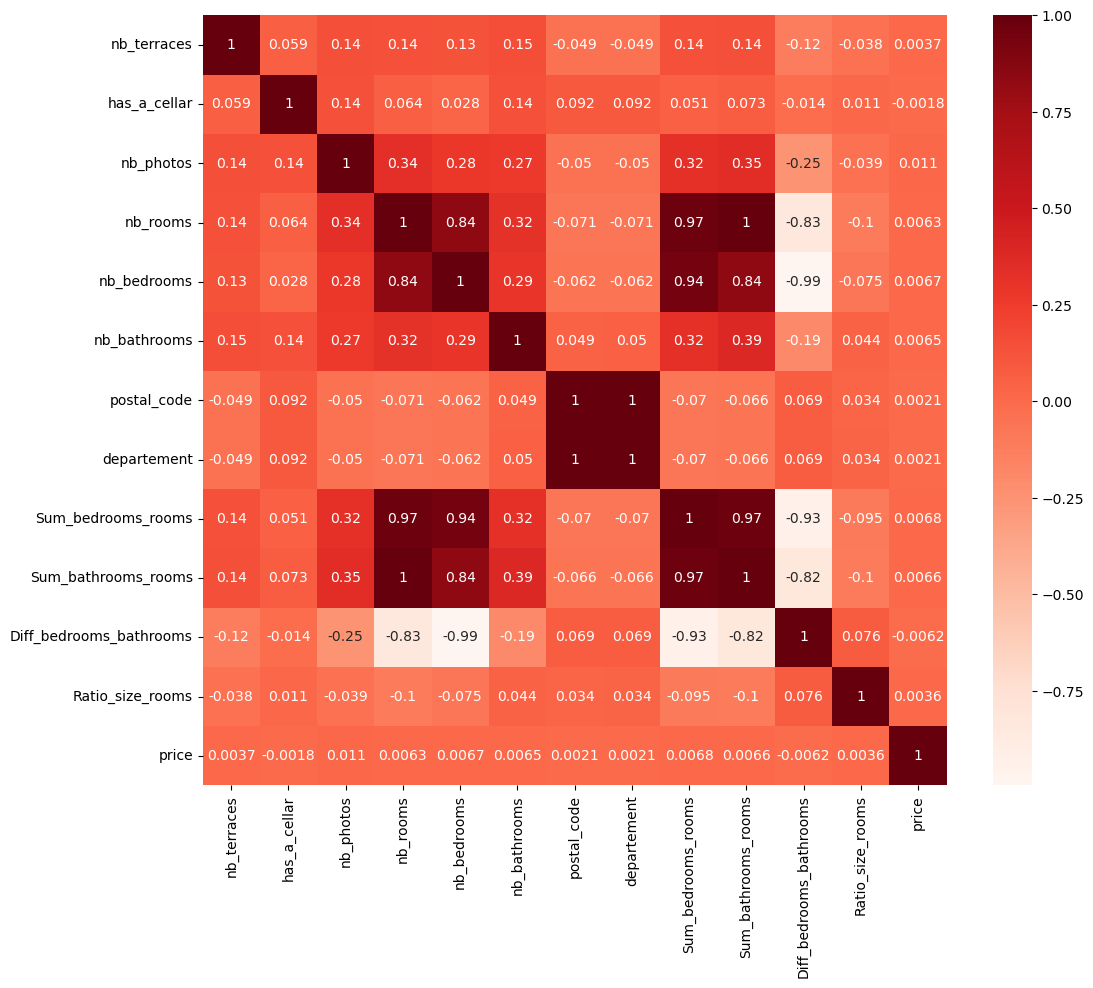

In [97]:
plt.figure(figsize=(12,10))
cor = X_correlation.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

> Dans les tentatives de rajout, les colonnes qui semblent intéressantes sont : Sum_bedrooms_rooms, Sum_bathrooms_rooms, Diff_bedrooms_bathrooms et departement. On les rajoute alors à X et on recalcule une heatmap :

In [98]:
X["Sum_bedrooms_rooms"] = X_correlation["Sum_bedrooms_rooms"]
X["Sum_bathrooms_rooms"] = X_correlation["Sum_bathrooms_rooms"]
X["Diff_bedrooms_bathrooms"] = X_correlation["Diff_bedrooms_bathrooms"]
X["departement"] = X_correlation["departement"]

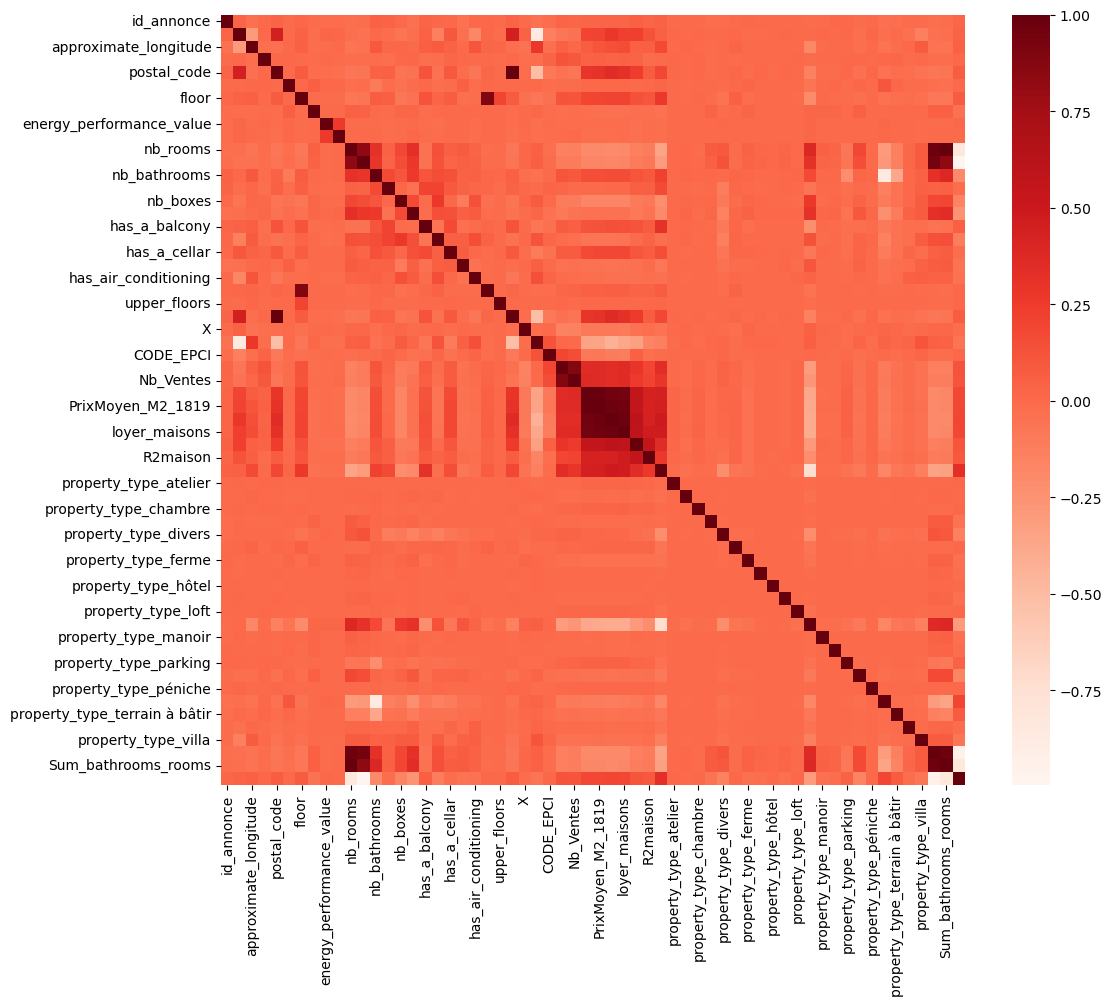

In [99]:
plt.figure(figsize=(12,10))
cor = X.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

> On vérifie le taux de données manquantes dans les colonnes nouvellement créées

In [100]:
colomnes = X.columns[X.isnull().any()]
nb_lignes = X.shape[0]
ratio_val_manquantes = {}


for col in colomnes:
    ratio_val_manquantes[col] = X[col].isnull().sum()/nb_lignes

ratio_val_manquantes = pd.DataFrame(ratio_val_manquantes.items(),columns = ["Nom Colonne","Ratio de valeurs manquantes"])
ratio_val_manquantes.sort_values(by = "Ratio de valeurs manquantes",ascending = False)

,Nom Colonne,Ratio de valeurs manquantes
0,CODE_EPCI,0.055395
1,PrixMoyen_M2_1819,0.006878


### Ajout de colonnes de prix approximés

In [101]:
X["nearly_price"]=X["PrixMoyen_M2"]*X["size"]

# fill missing values with mean column values (il reste des valeurs manquantes dans 'nearly_price_1819')
X.fillna(X.mean(), inplace=True)

### Ajout de racines de prix et de surface

In [102]:
X["racine_size"] = np.sqrt(X["size"])
X["racine_land_size"] = np.sqrt(X["land_size"])

### Ajout du score des images (obtenus par DL avec RoomNet)

> On merge les deux tables pour rajouter le score sur X

In [103]:
images_train = pd.read_csv("C:/Users/maila/Documents/Centrale Nantes/EI2/INFOIA/STASC/Data_Challenge/STASC/traitement_photos/donnees_finales_images_train.csv")
images_train_final = images_train[["id_annonce","score"]] # On ne garde que les colonnes qui nous intéressent

X = X.merge(images_train_final, how='left', left_on='id_annonce', right_on='id_annonce')

> Et pour finir, on drop la colonne correspondant aux ids des annonces

In [104]:
X = X.drop(columns=['id_annonce'],axis=1)

### Création de clusters

##### Cluster des prix

> On calcule des clusters pour les prix afin de me visualiser leur répartition. Cependant, il ne faut pas utiliser ce Cluster comme feature, car il a directement été créé à partir de la target qu'est le prix.

In [105]:
# création d'un mini dataset avec les coordonnées et le prix pour pouvoir faire un clustering
X_cluster_prix = X[["approximate_latitude", "approximate_longitude"]]
X_cluster_prix["price"]=y[["price"]]
# print(X_cluster_prix.head()) 

kmeans = KMeans(n_clusters=6)
X_cluster_prix["Cluster"] = kmeans.fit_predict(X_cluster_prix)
X_cluster_prix["Cluster"] = X_cluster_prix["Cluster"].astype("category")

X_cluster_prix.head()

,approximate_latitude,approximate_longitude,price,Cluster
0,43.643880,7.117183,355000.0,4
1,45.695757,4.895610,190000.0,0
2,47.966791,-1.220451,39000.0,0
3,47.289292,-1.878805,299000.0,4
4,45.718992,4.844234,478000.0,2


> Affichage graphique du clustering

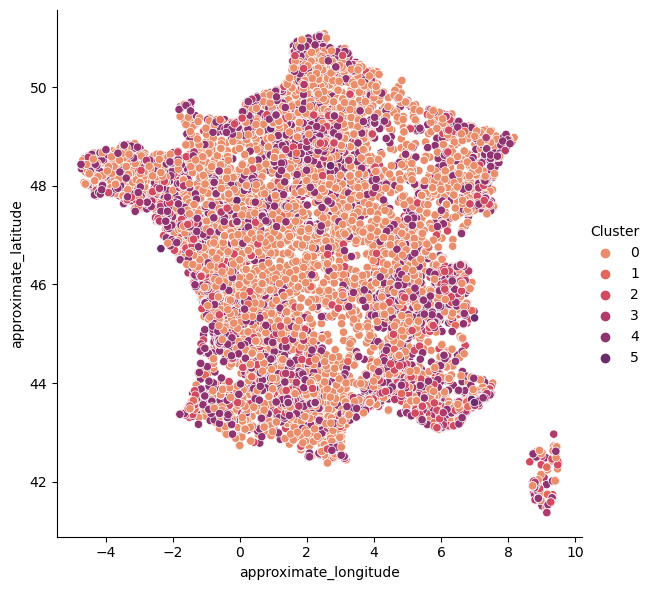

In [106]:
sns.relplot(x="approximate_longitude", y="approximate_latitude", hue = "Cluster", data=X_cluster_prix, height=6, palette = sns.color_palette("flare",n_colors = 6))

##### Création d'un clustering géographique avec la taille des biens

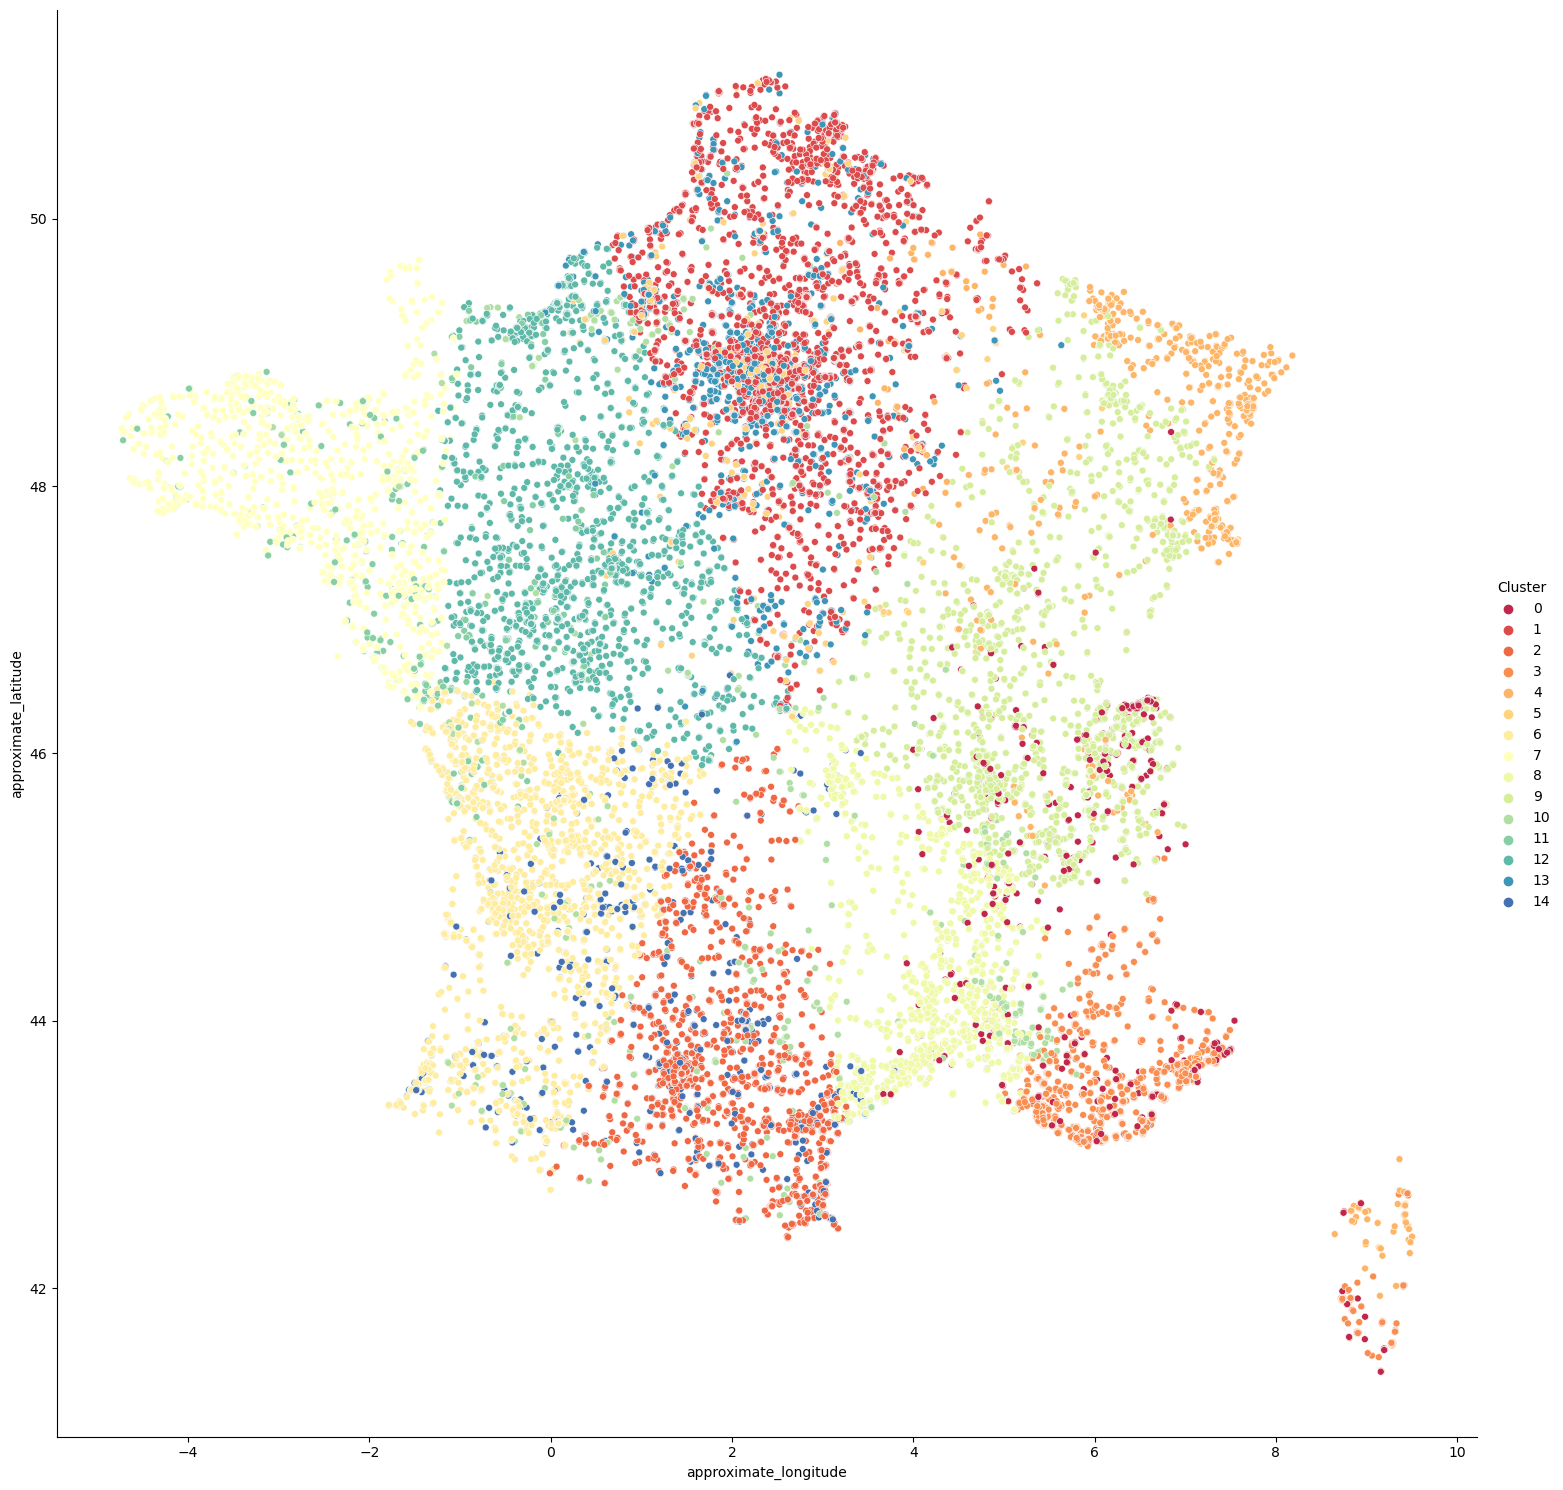

In [107]:
X_cluster_size = X[["approximate_longitude","approximate_latitude","nearly_price"]]
X_cluster_size["nearly_price"]=np.log1p(X_cluster_size["nearly_price"])
# print(X_cluster_prix.head())

N=15
kmeans = KMeans(n_clusters=N)
X_cluster_size["Cluster"] = kmeans.fit_predict(X_cluster_size)
X_cluster_size["Cluster"] = X_cluster_size["Cluster"].astype("category")
# print(X_cluster_size.head(10))

sns.relplot(x="approximate_longitude", y="approximate_latitude", hue = "Cluster", s=25,data=X_cluster_size, height=N, palette = sns.color_palette("Spectral",n_colors = N))

##### Feature Engineering final

> Le clustering semblant intéressant par étude de la feature importance, on va l'ajouter au dataset en même temps que différentes fonctions de preprocessing. Pour cela, on charge l'ensemble des datasets (train et test), soit X_avant_coupure et on applique directement l'ensemble des traitements dessus en créant deux fonctions qui résument le feature engineering et le preprocessing

In [241]:
def features_incomplete(X):   
    Features_incomplete = []
    for x in X.columns:
        if X[x].isnull().sum()/len(X[x])*100 > 0:
            Features_incomplete.append(x)
    return Features_incomplete

def FE(X):
    X.drop(columns = ["exposition"],inplace=True)
    X.drop(columns=['ghg_category', 'energy_performance_category'], inplace=True)
    X['floor'].fillna(0, inplace=True)
    X['land_size'].fillna(0, inplace=True)

    #one hot encoding for property_type
    X = pd.get_dummies(X, columns=['property_type'], drop_first=False)
    
    # Frequency encoding for city
    X['city'] = X['city'].map(X['city'].value_counts())


    # Calcul des valeurs des départements plutôt que des codes postaux (en séparant les départements à 4 chiffres des départements à 5 chiffres)
    X["departement"]=X["postal_code"]
    X["departement"][X["departement"] < 10000]=X["departement"].astype(str).str[:1].astype(int)
    X["departement"][X["departement"] >= 10000]=X["departement"].astype(str).str[:2].astype(int)

    # Tentatives de remplir les valeurs manquantes de ces colonnes par la valeur moyenne pour le code postal associé
    # X["POPULATION_x"].fillna(X.groupby("postal_code")["POPULATION_x"].transform("mean"), inplace=True)
    # X["Nb_Transac"].fillna(X.groupby("postal_code")["Nb_Transac"].transform("mean"), inplace=True)
    # X["Nb_Ventes"].fillna(X.groupby("postal_code")["Nb_Ventes"].transform("mean"), inplace=True)
    
    X["nearly_price"]=X["PrixMoyen_M2"]*X["size"]
    X["nearly_price_1819"]=X["PrixMoyen_M2_1819"]*X["size"]
    X["prix_metre"] = np.sqrt(X["PrixMoyen_M2"])
    X["prix_metre_1819"] = np.sqrt(X["PrixMoyen_M2_1819"])
    #------------------------------
    # X["prix_metre_2017"] = np.sqrt(X["Prix_2017"])
    # X["prix_metre_2018"] = np.sqrt(X["Prix_2018"])
    X["racine_size"] = np.sqrt(X["size"])
    X["racine_land_size"] = np.sqrt(X["land_size"])
    
    X["Somme_bedrooms_rooms"] = X["nb_rooms"]+X["nb_bedrooms"]
    X["Somme_bathrooms_rooms"] = X["nb_rooms"]+X["nb_bathrooms"]
    X["Diff_bedrooms_bathrooms"] = X["nb_bathrooms"]-X["nb_bedrooms"]

  
    # Prendre l'entier de la longitude et de la latitude
    X["approximate_longitude"]=X["approximate_longitude"].astype(int)
    X["approximate_latitude"]=X["approximate_latitude"].astype(int)
    
    
    for x in ["approximate_longitude","approximate_latitude","nearly_price"]:
    # On remplit le reste par la valeur moyenne du département
        X[x].fillna(X.groupby("departement")[x].transform("mean"), inplace=True)
    
    
    X = X.drop(columns = ["id_annonce"],axis=1)

    return X

In [177]:
def preprocessing(X_train, X_test):
    scaler = MinMaxScaler()
    for x in X_train.columns:
        if X_train[x].dtype != 'object':
            X_train[x] = scaler.fit_transform(X_train[x].values.reshape(-1,1))
            X_test[x] = scaler.transform(X_test[x].values.reshape(-1,1))

    # création d'un mini dataset avec les coordonnées et le prix pour pouvoir faire un clustering
    X_cluster_size = X_train[["approximate_longitude","approximate_latitude","nearly_price"]]

    N=15
    kmeans = KMeans(n_clusters=N)
    X_cluster_size["Cluster"] = kmeans.fit_predict(X_cluster_size)
    X_cluster_size["Cluster"] = X_cluster_size["Cluster"].astype("category")
    X_train["Cluster"]=X_cluster_size["Cluster"]
    X_test["Cluster"]=kmeans.predict(X_test[["approximate_longitude","approximate_latitude","nearly_price"]])

    scaler = MinMaxScaler()
    for x in X_train.columns:
        if X_train[x].dtype != 'object':
            X_train[x] = scaler.fit_transform(X_train[x].values.reshape(-1,1))
            X_test[x] = scaler.transform(X_test[x].values.reshape(-1,1))
    
    return X_train, X_test

In [242]:
X_AC = FE(X_AC)
X_train = X_AC.iloc[:len(X_train_site),:]
X_test = X_AC.iloc[len(X_train_site):,:]
X_train, X_test = preprocessing(X_train, X_test)

# Machine Learning

### Création d'un modèle de XGBoost

> Tout d'abord, on passe la colomne des prix au logarithme

In [ ]:
y_log_train = np.log1p(y_train)
y_log_train = y_log_train.reset_index(drop=True)

> Utilisation de GridSearchCV pour obtenir les meilleurs paramètres

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X_train, y_log_train, test_size=0.2, random_state=8)

my_kfold = KFold(n_splits = 5,shuffle = True)
features_improv = {"n_estimators" :[x for x in range(4000, 7000, 1000)], "max_depth" : [x for x in range(6,12,1)], "learning_rate" : [x/200 for x in range(1,10,1)], "subsample" : [x/10 for x in range(5,10,1)], "colsample_bytree" : [x/10 for x in range(1,10,1)]}

#xgbc = GridSearchCV(xgb.XGBRegressor(),param_grid=features_improv,cv=my_kfold,n_jobs=-1)
#xgbc.fit(train_X,train_y)
#print(xgbc.best_params_)

> On obtient alors : n_estimators=5000,max_depth = 9,learning_rate=0.08, colsample_bytree=0.5, subsample=0.9

### Entrainement du modèle

> On utilise la métrique demandée

In [ ]:
xgb_best = xgb.XGBRegressor(eval_metric = "mape",n_estimators=5000,max_depth = 9,learning_rate=0.08, colsample_bytree=0.5, subsample=0.9,n_jobs=-1)

xgb_best.fit(X_train,y_log_train)

### On effectue finalement les prédictions

In [ ]:
prediction_y = xgb_best.predict(X_test)

Y_final = pd.DataFrame({"price" : np.expm1(prediction_y)})
Y_final.set_index(annonces, inplace=True)

Y_final.to_csv("y_pred_12_01_4.csv")

### Observation de la feature importance

In [ ]:
xgb.plot_importance(xgb_best,max_num_features = 20)

> Rajouter le dataset des prix de 2017 et de 2018 pour décommenter la ligne dans FE + Ensemble Learning + vérifier les problèmes de valeurs nulles lors du merge du dataset des prix de 2019 (on devrait en avoir moins ?)

X.rename(columns = {'Prixm2_Moy':'Prix_2018','Prixm2' : 'Prix_2017'}, inplace = True)

De plus "Nb_Transac" appartient au dataset de 2018 (donc à ne pas supprimer plus haut)

> "POPULATION_x" semble juste s'appeler POPULATION

> sur le fichier "UX_insee", de nombreuses colomnes de merge semblent avoir été dupliqués sous deux noms : Col_x et Col_y (c'est le cas de POPULATION)